In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import chainer
import chainer.links as L
import chainer.functions as F
from chainer.training import extensions

In [2]:
# define class and function
class MultiLayerPerceptron(chainer.Chain):
    """Class of deep neural network(DNN) description
    
    Args:
        nodes(list of int):Nodes of network layers
        dropout(float):Dropout ratio
    """
    
    def __init__(self,nodes):
        #superは親ｸﾗｽ呼び出し。
        #この場合は、親ｸﾗｽであるchainer.Chainの__init__
        #ﾒｿｯﾄﾞを呼び出して使ってる
        super(MultiLayerPerceptron, self).__init__()
        self.nodes = nodes
        self.layers = len(self.nodes)
        for i in range(self.layers-1):
            self.add_link("l{}".format(i),
                          L.Linear(self.nodes[i],
                                   self.nodes[i+1]))
        
    def __call__(self,x):
        """Return predictive values.
        
        Args:
            x([chainer]Variable):Input of DNN
        Returns:
            y([chainer]Variable):Output of DNN
        """
        y = self["l0"](x)
        for i in range(self.layers-2):
            h = F.relu(y)
            y = self["l{}".format(i+1)](h)
        return y
    
def train_test_tuple_dataset(x,y,test_ratio):
    """Make training & testing data set.

    Args:
        x([numpy]ndarray):Input series
        y([numpy]ndarray):Output series
        test_ratio(float):Test data ratio in (0,1)
    """
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = test_ratio)
    train = chainer.datasets.TupleDataset(x_train, y_train)
    test = chainer.datasets.TupleDataset(x_test, y_test)
    return train,test
    
def myplot(p,y,color='blue'):
    """Plot predict values and actual values.

    Args:
        p([numpy]ndarray):Predict values
        y([numpy]ndarray):Actual values
        color(str):Graph color name
    """
    y_ncol = y.shape[1]
    e = (p-y)/y*100
    means = np.average(e,axis=0)
    sds = np.std(e,axis = 0)
    fig, axes = plt.subplots(nrows=1,ncols=y_ncol,figsize=(3.5*y_ncol,2.5),sharex=True,sharey=True)
    for i in range(y_ncol):
        if y_ncol>1:
            ax = axes[i]
        else:
            ax = axes
        yimax = (1.05*max([p[:,i].max(),y[:,i].max()]))
        ax.grid(color = 'lightgray', linestyle='--')
        ax.scatter(p[:,i], y[:,i], color = color,
                  label="N:{0}\nmean: {1:.2f}%\nsd: {2:.2f}%".format(len(y), means[i],sds[i]))
        ax.plot([0, yimax], [0, yimax])
        ax.legend()

In [5]:
#define csv file
data_csv_file = "5411.csv"

#input columns' name
x_columns = ['Open']

#predict columns' name
y_columns = ['Close']

#network parameters
layer_number = 4
hidden_node_number = 100

#training conditions
io_normalization = True
train_data_number = 1500
epoch_number =100
batch_size = 100
#学習係数等のparameterはAdam内に入ってる
optimizer = chainer.optimizers.Adam()
mylossfun = F.mean_squared_error
myaccfun = F.r2_score

gpu_device = -1 #IF you use gpu, set gpu number(e.g. gpu_device = 0)

#make data set
df = pd.read_csv(data_csv_file, sep=',')

xs = df[x_columns]
ys = df[y_columns]

if io_normalization:
    from sklearn.preprocessing import StandardScaler
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    xs_f = x_scaler.fit_transform(xs).astype(np.float32)
    ys_f = y_scaler.fit_transform(ys).astype(np.float32)
else:
    x_scaler = None
    y_scaler = None
    xs_f = xs.values.astype(np.float32)
    ys_f = ys.values.astype(np.float32)
    
assert train_data_number < df.shape[0]
test_ratio = 1-train_data_number/df.shape[0]
train, test = train_test_tuple_dataset(xs_f, ys_f, test_ratio)

nodes = [hidden_node_number]*layer_number
nodes[0] = len(x_columns)
nodes[-1] = len(y_columns)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x82 in position 2: invalid start byte

In [ ]:
#define multilayer perceptron network
model = L.Classifier(MultiLayerPerceptron(nodes),
                    lossfun = mylossfun,
                    accfun = myaccfun)

In [4]:
#setup training enviroments
optimizer.setup(model)
train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle = False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device = gpu_device)
trainer = chainer.training.Trainer(updater, (epoch_number, 'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model, device = gpu_device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch',
                                      'iteration',
                                      'elapsed_time',
                                      'main/loss',
                                      'validation/main/loss',
                                      'main/accuracy',
                                      'validation/main/accuracy']))

#exec.training
trainer.run()

if gpu_device >= 0:
    model.to_cpu()

NameError: name 'model' is not defined

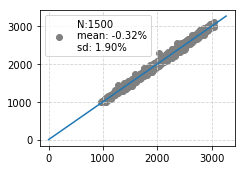

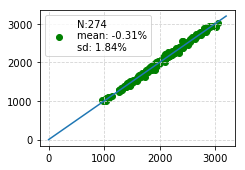

In [6]:
def myplot_aux(model, tuple_dataset, y_scaler = None):
    x = np.array([_x for _x in np.array(tuple_dataset)[:,0]])
    t = np.array([_t for _t in np.array(tuple_dataset)[:,1]])
    
    y = model(x).data
    if y_scaler is not None:
        t = y_scaler.inverse_transform(t)
        y = y_scaler.inverse_transform(y)
    return t, y
model.predictor
t, y = myplot_aux(model.predictor, train, y_scaler)
myplot(t, y, color = 'gray')
t, y = myplot_aux(model.predictor, test, y_scaler)
myplot(t, y, color='green')

try:
    y_sch = df[y_columns].values
    p_sch = df[[col + 'sch' for col in y_columns]].values
    myplot(y_sch, p_sch)
except:
    pass

plt.show()

In [11]:
#ﾓﾃﾞﾙの中身(重み,ﾊﾞｲｱｽ、各種条件をcsv出力)
W0 = model.predictor["l{}".format(0)].W.data
b0 = model.predictor["l{}".format(0)].b.data
W1 = model.predictor["l{}".format(1)].W.data
b1 = model.predictor["l{}".format(1)].b.data
W2 = model.predictor["l{}".format(2)].W.data
W2 = W2.T
b2 = model.predictor["l{}".format(2)].b.data
np.set_printoptions( suppress=True)

W0_p = pd.DataFrame(W0)
b0_p = pd.DataFrame(b0)
W1_p = pd.DataFrame(W1)
b1_p = pd.DataFrame(b1)
W2_p = pd.DataFrame(W2)
b2_p = pd.DataFrame(b2)

W0_name = pd.DataFrame(['W0='])
b0_name = pd.DataFrame(['b0='])
W1_name = pd.DataFrame(['W1='])
b1_name = pd.DataFrame(['b1='])
W2_name = pd.DataFrame(['W2='])
b2_name = pd.DataFrame(['b2='])

df = pd.concat([W0_name,W0_p,
                b0_name,b0_p,
                W1_name,W1_p,
                b1_name,b1_p,
                W2_name,W2_p,
                b2_name,b2_p], axis = 1)
i = [1]

#input columns' name
df_con = pd.DataFrame({ '0_in' : i,
                        '1_io_normalization' : io_normalization,
                        '2_epoch_number' : epoch_number,
                        '3_train_data_number' : train_data_number,
                        '4_epoch_number' : epoch_number,
                        '5_batch_size' : batch_size,
                        '6_optimizer' : 'Adam',
                        '7_mylossfun' : 'MSE',
                        '8_layer_number' : layer_number,
                        '9_hidden_node_number' : hidden_node_number,
                        'A_read_file' : data_csv_file,
                        'B_input' : x_columns,
                        'C_output': y_columns})

df = pd.concat([df,df_con], axis = 1)

df.to_csv('DNN_parameters.csv',index = False)